# Pipeline Documentation
### The goal of there experiments is to look for inter-animal neuronal synchrony. We do this by correlating normalized cell activity across animals. 
#### This Notebook shows how functions work by pulling them from each separate file in the src directory and shows example output by correlating subsets of 2 real sample datasets:
- HW_Repos/Synchrony-Anaysis-Pipeline-SE4S/data/4659_aligned_short.csv
- HW_Repos/Synchrony-Anaysis-Pipeline-SE4S/data/4807_aligned_short.csv

The cells (named '003'-'C019') from each animal were taken from the processed datasets. These two animals' calcuim flourecence (a proxy for neuronal activity) were recored at the same time while the subjects were interacting with each other. 

In [2]:
#  Importing all the modules needed for all steps here:
import sys
sys.path.insert(0, '../src')
import pandas as pd
import numpy as np
import df_utils
from animal_data import AnimalData
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

#  Step 1: loading data into the data loader
##  File: src/animal_data.py
AnimalData (imported from the file above) is a class structure where the data from a csv file is loaded into the structure with several methods:
- get_data_for_cell(cell, n=None): Returns a list of (timestamp, value) tuples for the specified cell.
- get_data_at_time(timestamp): Returns a dictionary with cells as keys and measurements at a specific timestamp as values.
- save_to_csv(output_path): Saves the cell data into a CSV file at the specified path.
- from_csv(filepath): Class method to create an AnimalData instance from a CSV file.

This allows the data to be cleaned and tested before moving on, and allows data for specific cells to be pulled out quickly

In [10]:
animal_1_data = AnimalData.from_csv('../data/4659_aligned_short.csv')
animal_2_data = AnimalData.from_csv('../data/4807_aligned_short.csv')

# Step 2: normalizing data
## File: src/normalize_data.py
The data for each animal needs to be normalized so that each cell's signal can be compared across cells within and between animals. With this method each cell's max value is 1.

In [4]:
def normalize_df(ani_data, cells=None):
    """
    Normalizes cell df/f data by dividing each cell column
    by the max value in each column so that each cells max
    value in the normalized dataframe is 1.
    Args:
        ani_data: data from session in AnimalData
             class structure
        cells: list of cells names (str) to normalize,
            defalt=None will normalize all cells in dataset
    Returns: dfn, a dataframe of normalized data
    """
    if cells is None:
        cells = ani_data.cell_data.keys()
    df = df_utils.animal_data_to_df(ani_data, cells)
    if df is None:
        print('unable to normalize data if unable to convert to dataframe')
        return None
    try:
        max_values = df.max(axis=0)
        dfn = df / max_values
        return dfn
    except TypeError:
        print('df values are not numbers')
        return None

In [11]:
animal_1_norm_data = normalize_df(animal_1_data)
animal_2_norm_data = normalize_df(animal_2_data)

In [12]:
animal_1_norm_data.head()

,C003,C004,C005,C006,C007,C008,C009,C010,C011,C012,C013,C014,C015,C016,C017,C018,C019
0,0.113015,0.109288,0.098762,0.024784,0.039973,-0.042553,0.077536,-0.016178,0.065426,0.137033,0.194059,-0.057921,0.150053,0.050014,0.077647,0.035843,0.056894
1,0.100210,0.101385,0.124707,0.032507,0.070780,-0.026035,0.024572,-0.040949,-0.028401,0.145514,0.624892,-0.057989,0.061933,-0.026174,0.139383,0.081296,0.031088
2,0.034191,0.100621,0.060947,0.050587,-0.013786,0.078224,-0.040108,-0.008302,-0.027811,0.085026,0.669865,-0.058053,0.052570,0.033644,0.080430,0.044630,-0.004567
3,0.022911,0.086278,0.044970,0.167771,-0.022402,0.041289,0.035207,-0.048966,-0.067946,0.088125,0.509163,-0.058114,0.051278,-0.061025,0.007509,0.034648,0.005950
4,0.031047,0.068061,0.153994,0.229227,-0.039860,0.002946,-0.001509,-0.006574,-0.154327,-0.002733,0.433808,-0.058173,0.098939,0.000296,0.092694,0.044681,0.027570


In [13]:
animal_2_norm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12355 entries, 0 to 12354
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C003    12355 non-null  float64
 1   C004    12355 non-null  float64
 2   C005    12355 non-null  float64
 3   C006    12355 non-null  float64
 4   C007    12355 non-null  float64
 5   C008    12355 non-null  float64
 6   C009    12355 non-null  float64
 7   C010    12355 non-null  float64
 8   C011    12355 non-null  float64
 9   C012    12355 non-null  float64
 10  C013    12355 non-null  float64
 11  C014    12355 non-null  float64
 12  C015    12355 non-null  float64
 13  C016    12355 non-null  float64
 14  C017    12355 non-null  float64
 15  C018    12355 non-null  float64
 16  C019    12355 non-null  float64
dtypes: float64(17)
memory usage: 1.6 MB


# Step 3: correlate cells between animals
## File: src/correlations.py
The normalized data for each animal then gets correlated to see if cells in the 2 animals have similar activity over time, both r and p values are output and saved

In [18]:
def correlation_matrix(dataframe1, dataframe2):
    """
    Takes two dataframes of cell data and correlates all cells
    between the dataframes. Outputs two dataframes of p-values
    and R values for every correlation. Different size dataframes
    are cut to be the same length, and missing data is removed.
        Args: dataframe1, dataframe2 are the two dataframes to
        correlate. The cell names of dataframe1 will be the
        index of the output, and the cells in dataframe2 will be
        the column names.
        """
    data1 = dataframe1
    data2 = dataframe2

    col1 = [c for c in data1.columns.values]
    col2 = [c for c in data2.columns.values]

    # convert columns to numpy to correlate
    # if all values in the column are the same NaN values will be returned
    corr_p = pd.DataFrame(data=[], index=col1, columns=col2)
    corr_r = pd.DataFrame(data=[], index=col1, columns=col2)

    # cut off extra data from end so dataframes can be the same length
    len1 = len(data1)
    len2 = len(data2)

    if len1 != len2:
        if len1 > len2:
            data1 = data1.iloc[:len2]
            print('dataframe 1 too long - cut off to match')
        elif len2 > len1:
            data2 = data2.iloc[:len1]
            print('dataframe 2 too long - cut off to match')
        else:
            print('error matching lengths')
            sys.exit(1)

    for c1 in col1:
        for c2 in col2:
            a1 = data1[c1].astype(float)
            a2 = data2[c2].astype(float)

            # drop times where 1 value is nan/missing from either array
            a1 = a1[~np.isnan(a2)]
            a2 = a2[~np.isnan(a1)]

            a1 = a1[~np.isnan(a1)]
            a2 = a2[~np.isnan(a2)]

            try:
                (r, p) = sps.pearsonr(a1, a2)
            except:  # noqa
                print('unable to calculate correlation')
                sys.exit(1)

            corr_p.loc[c1, c2] = p
            corr_r.loc[c1, c2] = r

    return corr_p, corr_r


In [25]:
p_value_matrix, r_value_matrix = correlation_matrix(animal_1_norm_data, animal_2_norm_data)

In [26]:
r_value_matrix

,C003,C004,C005,C006,C007,C008,C009,C010,C011,C012,C013,C014,C015,C016,C017,C018,C019
C003,-0.03045,-0.000406,0.085862,-0.011,0.037347,0.080002,0.026356,-0.048106,0.082944,0.103579,0.046318,-0.106616,-0.013887,-0.114815,0.09948,-0.088874,0.01657
C004,-0.014135,-0.143663,-0.002425,-0.186303,-0.078658,0.011203,0.013865,-0.113195,0.182559,0.098797,-0.031603,-0.151682,0.068141,-0.055267,0.142449,-0.08616,-0.102648
C005,0.003584,0.026971,0.028284,-0.069172,-0.069602,-0.02873,-0.021994,-0.021295,0.079625,-0.114604,0.034564,0.045935,0.02364,-0.193645,0.040071,0.04284,-0.022629
C006,0.03271,-0.044051,0.101827,-0.077006,-0.083981,-0.035683,-0.025427,-0.030831,0.102108,-0.018736,0.051032,-0.037596,-0.032412,-0.022161,0.032493,-0.058234,-0.047945
C007,0.017673,-0.114776,-0.225095,-0.215192,0.334832,0.248993,0.386519,0.371783,-0.137472,0.044708,-0.099616,-0.232246,0.035605,0.103143,-0.014181,-0.135794,-0.051807
C008,-0.029487,-0.070068,0.058585,-0.151828,-0.095843,0.018698,0.050542,-0.055214,0.076367,-0.058284,0.007894,-0.103459,0.058558,-0.136477,0.065926,-0.07952,-0.127574
C009,0.016527,0.081728,0.013639,0.142347,-0.030321,-0.069563,-0.075833,0.060015,-0.04644,0.035935,0.068634,0.121905,-0.033667,-0.000478,-0.036513,0.117235,0.134089
C010,0.01341,-0.05004,0.047584,-0.169459,-0.166245,0.033146,0.017165,-0.170289,0.138301,-0.027035,0.021161,-0.124882,0.008585,-0.100131,0.113324,-0.092963,-0.132859
C011,0.105216,-0.093844,-0.144855,-0.152952,0.186352,0.063824,0.065921,0.279328,-0.146119,0.069424,-0.125019,-0.124713,-0.008934,0.272838,-0.116745,-0.080448,0.102506
C012,0.016815,0.043388,0.028638,0.171802,-0.00939,-0.106557,-0.121065,-0.100186,0.087927,0.055782,0.082682,0.121486,-0.014457,-0.011678,0.044766,0.083223,0.058883


In [27]:
p_value_matrix

,C003,C004,C005,C006,C007,C008,C009,C010,C011,C012,C013,C014,C015,C016,C017,C018,C019
C003,0.000712,0.964025,0.0,0.221488,0.000033,0.0,0.003392,0.0,0.0,0.0,0.0,0.0,0.12271,0.0,0.0,0.0,0.065508
C004,0.116169,0.0,0.787536,0.0,0.0,0.213092,0.123302,0.0,0.0,0.0,0.000443,0.0,0.0,0.0,0.0,0.0,0.0
C005,0.690353,0.002716,0.001666,0.0,0.0,0.001404,0.014496,0.017932,0.0,0.0,0.000122,0.0,0.008595,0.0,0.000008,0.000002,0.011892
C006,0.000276,0.000001,0.0,0.0,0.0,0.000073,0.004707,0.000609,0.0,0.037296,0.0,0.000029,0.000314,0.013767,0.000304,0.0,0.0
C007,0.049485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.0,0.0,0.000075,0.0,0.114997,0.0,0.0
C008,0.001045,0.0,0.0,0.0,0.0,0.03768,0.0,0.0,0.0,0.0,0.380261,0.0,0.0,0.0,0.0,0.0,0.0
C009,0.066215,0.0,0.129528,0.0,0.00075,0.0,0.0,0.0,0.0,0.000065,0.0,0.0,0.000182,0.957626,0.000049,0.0,0.0
C010,0.136109,0.0,0.0,0.0,0.0,0.000229,0.056408,0.0,0.0,0.002653,0.018666,0.0,0.339984,0.0,0.0,0.0,0.0
C011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.320703,0.0,0.0,0.0,0.0
C012,0.061626,0.000001,0.001455,0.0,0.296624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108077,0.194305,0.000001,0.0,0.0


# Step 4: finding cell pairs with high correlation
## File: src/cell_slicer.py
Using the correlation matrices the cell slicer collapses and sorts the r values and then returns a list of cell pairs (tuple of cell names from animal1, animal2) that are either significant (using the p values and alpha > 0.05) or have the top x percent r values

In [19]:
def cell_query(r_data, query, p_data=None, x_percent=None, alpha=0.05):
    """
    sorts correlation cell pairs and returns list of cell pairs based on query
    query can be either based on significance or the top x percent of r values
    Args:
        r_data: correlation dataframe of r values
        query: sig or top, string of sorting method
        p_data: dataframe of correlation p values, default None
        x_percent: top percent to slice, int, default None
        alpha: significance cutoff, default 0.05
    Returns:
        cell_pairs: list of cell pair tuples of string cell names
        sorted_matrix: series of sorted r values from correlation matrix
        sorted_p_matrix: series of sorted p values from correlation matrix
            if query is top this is returned as None
    """
    try:
        # Convert to 1-D series and drop Null values
        unique_corr_pairs = r_data.unstack().dropna()
        # Sort corr pairs, need to keep values but sort based on absolute value
        order = unique_corr_pairs.abs().sort_values(ascending=False)
        ind = order.index
        sorted_matrix = unique_corr_pairs[ind]
        # python dicts are now sorted so this works to keep sorted order
        sorted_cell_pairs = sorted_matrix.keys()
    except TypeError:
        print('r_data matrix not numbers')
        return None

    # slice based on correlation signinficance:
    if query == 'sig':
        if p_data is None:
            print('Error if query is sig must input p_data')
            return None
        else:
            #  also sorting p values
            p_unique_corr_pairs = p_data.unstack().dropna()
            p_sorted_matrix = p_unique_corr_pairs.sort_values()
            p_sorted_cell_pairs = p_sorted_matrix.keys()

            try:
                #  making slice of series based on alpha
                sig_cell_pairs = p_sorted_matrix.loc[:, p_sorted_matrix.loc[:]
                                                     < alpha]
                #  getting the cell pair names into a list
                x_len = len(sig_cell_pairs)
                cell_pairs = []
                for i in range(x_len):
                    cells = p_sorted_cell_pairs[i]
                    cell_pairs.append(cells)
                return cell_pairs, sorted_matrix, p_sorted_matrix
            except TypeError:
                print('p_data matrix not numbers')
                return None

    #  slice based on top x percent
    elif query == 'top':
        if x_percent is None:
            print('Error if query is top must input x_per')
            return None
        else:
            #  turing int into float percentage
            per = x_percent/100
            cells_length = len(sorted_cell_pairs)
            #  have to round to a int number of pairs
            x_len = round(cells_length*per)
            if x_len == 0:
                print('percent is too low to round to 1 pair')
            cell_pairs = []
            for i in range(x_len):
                cells = sorted_cell_pairs[i]
                cell_pairs.append(cells)
            return cell_pairs, sorted_matrix, None

    else:
        print('Error query must be sig or top')
        return None

In [28]:
sig_cell_pairs, sorted_r_values, sorted_p_values = cell_query(r_value_matrix, 'sig', p_data=p_value_matrix)

In [29]:
print(sig_cell_pairs)

[('C010', 'C007'), ('C009', 'C007'), ('C010', 'C015'), ('C007', 'C007'), ('C016', 'C015'), ('C005', 'C015'), ('C009', 'C019'), ('C010', 'C017'), ('C006', 'C016'), ('C010', 'C013'), ('C010', 'C011'), ('C007', 'C019'), ('C016', 'C011'), ('C006', 'C019'), ('C007', 'C015'), ('C007', 'C017'), ('C008', 'C007'), ('C016', 'C013'), ('C008', 'C016'), ('C014', 'C007'), ('C011', 'C015'), ('C005', 'C007'), ('C009', 'C015'), ('C006', 'C007'), ('C008', 'C019'), ('C008', 'C017'), ('C008', 'C015'), ('C010', 'C019'), ('C009', 'C017'), ('C004', 'C016'), ('C016', 'C005'), ('C005', 'C017'), ('C006', 'C017'), ('C007', 'C011'), ('C006', 'C004'), ('C006', 'C015'), ('C009', 'C016'), ('C011', 'C004'), ('C014', 'C019'), ('C006', 'C014'), ('C013', 'C015'), ('C006', 'C012'), ('C010', 'C010'), ('C006', 'C010'), ('C007', 'C010'), ('C014', 'C015'), ('C007', 'C014'), ('C006', 'C011'), ('C004', 'C019'), ('C005', 'C013'), ('C006', 'C008'), ('C014', 'C004'), ('C005', 'C019'), ('C010', 'C014'), ('C011', 'C011'), ('C005', 

In [30]:
sorted_r_values

C010  C015    0.452195
C009  C007    0.386519
C010  C007    0.371783
C007  C007    0.334832
C016  C015    0.314609
                ...   
C015  C018    0.001964
C016  C016    0.001205
C013  C016    0.000728
C016  C009   -0.000478
C004  C003   -0.000406
Length: 289, dtype: object

In [31]:
sorted_p_values

C010  C007         0.0
C009  C007         0.0
C010  C015         0.0
C007  C007         0.0
C016  C015         0.0
                ...   
C015  C018    0.827198
C016  C016    0.893489
C013  C016    0.935501
C016  C009    0.957626
C004  C003    0.964025
Length: 289, dtype: object

In [32]:
# cell query always returns 3 things, but the query 'top' doesn't use p values so it returns None in the 3rd spot
top_1_per_cell_pairs, sorted_r_values_repeat, none = cell_query(r_value_matrix, 'top', x_percent=1)

In [33]:
top_1_per_cell_pairs

[('C010', 'C015'), ('C009', 'C007'), ('C010', 'C007')]

# Step 5: data visualization
## File: src/create_plots.py
Now that we have cell pairs of interest, we can graph the traces of their activity over time to visualize the correlation. We can also plot the correlation matrix to visualize the numeric correlation of all cells.

In [34]:
#  again, the class structure is useful for pulling out data by cell, which we want to do now with the normalized data
#  these normalized datasets were calculated from the sample data with normalize_df and saved previously
ani1_norm_data = AnimalData.from_csv('../data/4659_normalized_short.csv')
ani2_norm_data = AnimalData.from_csv('../data/4807_normalized_short.csv')

In [47]:
# the timestamps didn't get transfered to 
df = pd.read_csv('../data/4659_aligned_traces.csv')
elapsed_time = df['elapsed']

In [35]:
# line plots for 1 animal data
def create_line_plot(data, cells, output_filename):
    """Generates line plot of neural activity over time for cells."""
    try:
        plt.figure(figsize=(12, 7))
        for cell in cells:
            data_for_cell = data.get_data_for_cell(cell)
            # Check if data_for_cell is empty
            if not data_for_cell:
                raise ValueError(f"Cell not found in data")
            # Unpacking the tuple into three variables
            # We throw away the second value, elapsed time
            timestamps, _, values = zip(*data_for_cell)
            plt.plot(timestamps, values, label=cell)

        plt.xlabel('Timestamp')
        plt.ylabel('Neural Activity Value')
        plt.title('Neural Activity Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(output_filename)

    except ValueError as e:
        print(e)
        sys.exit(1)
    except Exception as e:
        print("Could not create line plot")
        sys.exit(1)

In [84]:
# function for graphing cell pairs
def create_2_ani_line_plot(a1_data, a2_data, cell_pair, output_filename):
    """Generates line plot of neural activity over time for cells."""
    try:
        cell_1 = cell_pair[0]
        cell_2 = cell_pair[1]
        
        plt.figure(figsize=(15, 7))
        
        cell_1_data = a1_data.get_data_for_cell(cell_1)
        timestamps1, elapsed1, values1 = zip(*(cell_1_data))
        plt.plot(elapsed_time, values1, label=cell_1, alpha=0.7)
        timestamps2, elapsed2, values2 = zip(*(a2_data.get_data_for_cell(cell_2)))
        plt.plot(elapsed_time, values2, label=cell_2, alpha=0.7)
        plt.xlabel('Elapsed time (s)')
        plt.ylabel('Normalized neural activity')
        plt.title(cell_1 + ', ' + cell_2 + ' Cell Pair Activity Traces Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(output_filename)
        plt.show()
    except ValueError as e:
        print(e)
        sys.exit(1)
    except Exception as e:
        print("Could not create line plot")
        sys.exit(1)

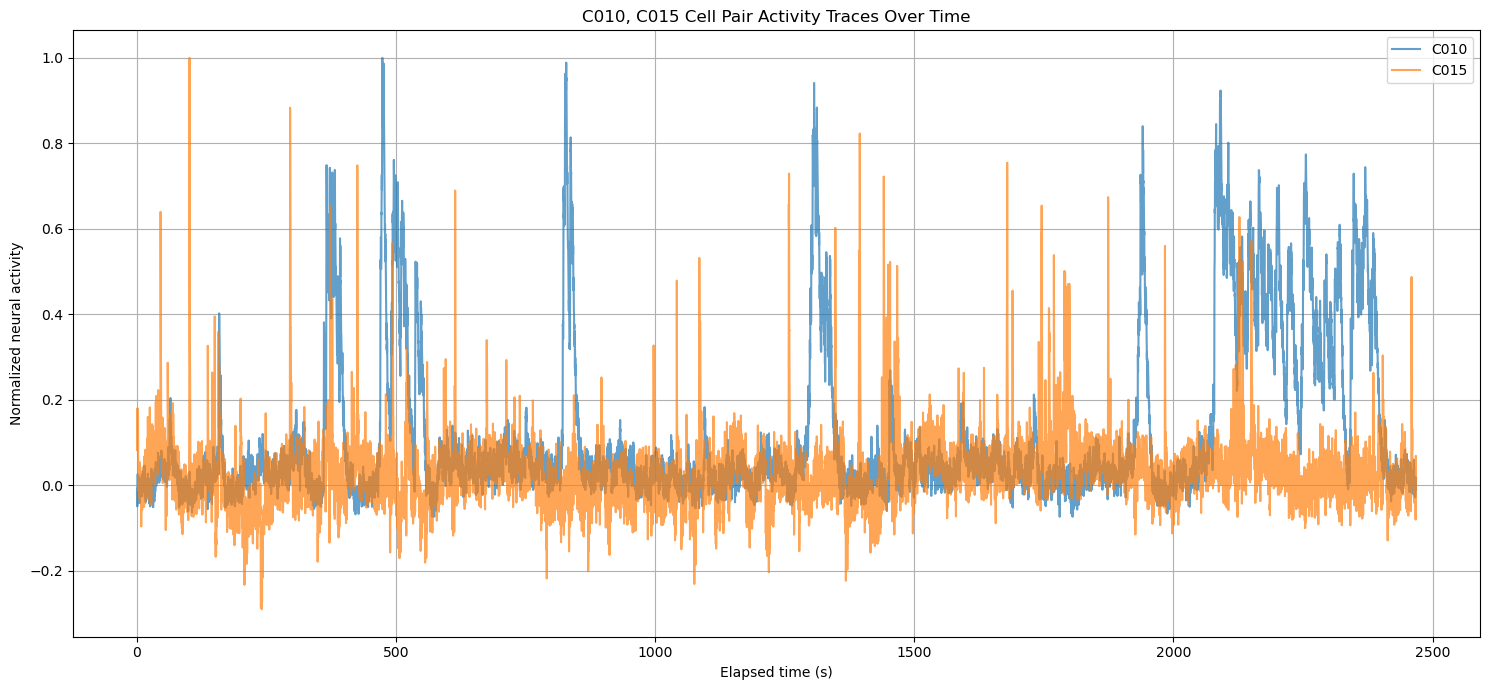

In [85]:
create_2_ani_line_plot(ani1_norm_data, ani2_norm_data, top_1_per_cell_pairs[0], 'pair_10_15_traces.png')

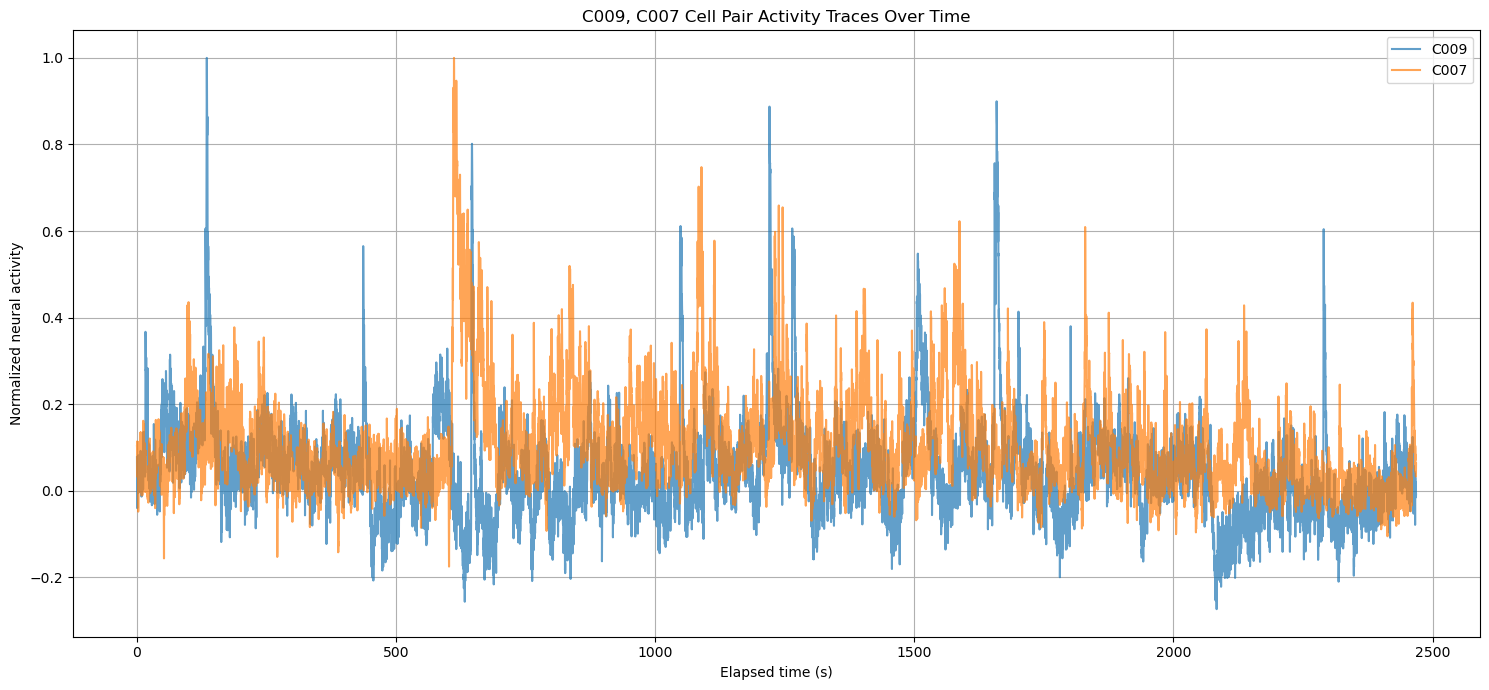

In [86]:
create_2_ani_line_plot(ani1_norm_data, ani2_norm_data, top_1_per_cell_pairs[1], 'pair_9_7_traces.png')

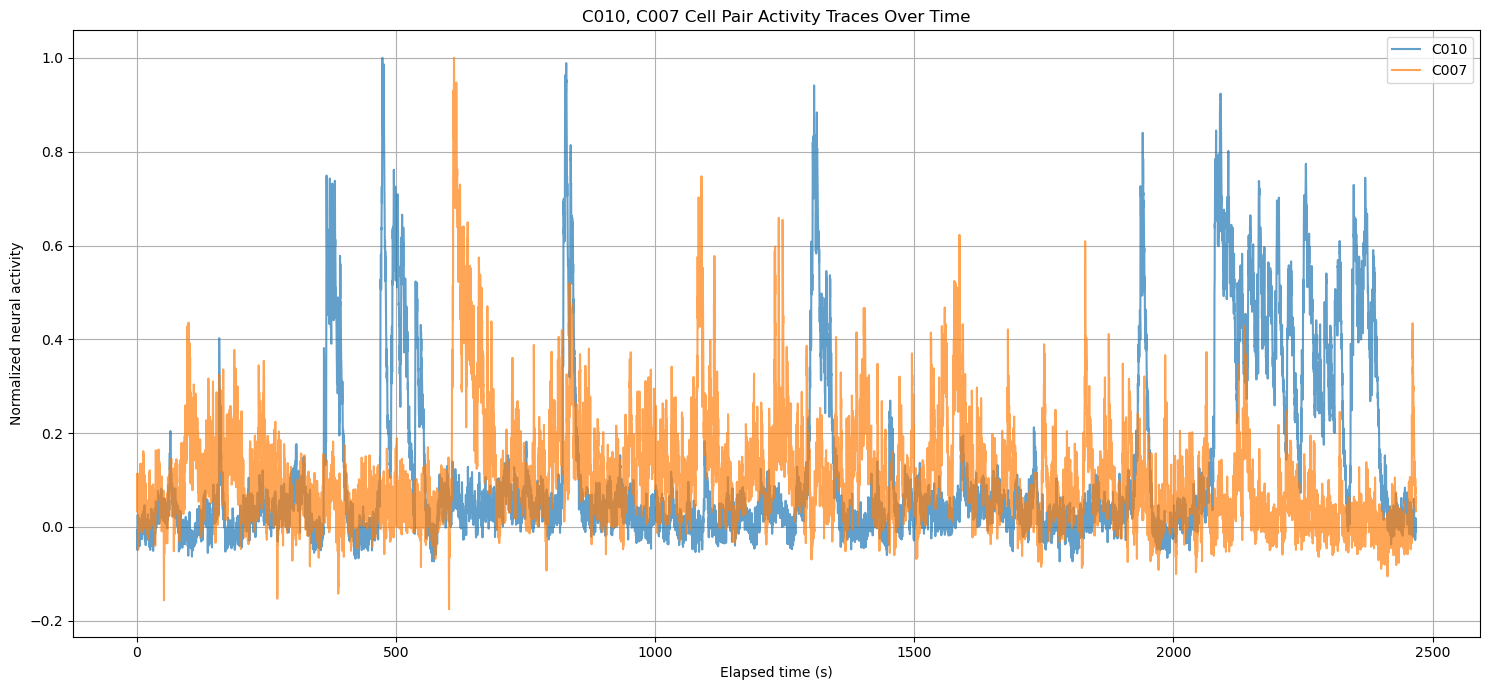

In [87]:
create_2_ani_line_plot(ani1_norm_data, ani2_norm_data, top_1_per_cell_pairs[2], 'pair_10_7_traces.png')

In [59]:
def create_correlation_matrix(data, cells, output_filename):
    """Generate heatmap of correlation matrix of neural activity."""
    try:
        subset_data = {
            cell: [value for _, _, value in data.get_data_for_cell(cell)]
            for cell in cells
        }
        # Check if subset_data is empty
        if not subset_data:
            raise ValueError(f"No data")
        # Create dataframe to get easy correlation matrix functionality
        df = pd.DataFrame(subset_data)
        correlation_matrix = df.corr()

    except ValueError as e:
        print(e)
        sys.exit(1)
    except Exception as e:
        print("Could not create correlation matrix")
        sys.exit(1)

    plt.figure(figsize=(12, 7))
    sns.heatmap(correlation_matrix, annot=True,
                cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Neural Activity')
    plt.tight_layout()
    # plt.savefig(output_filename)
    plt.show()

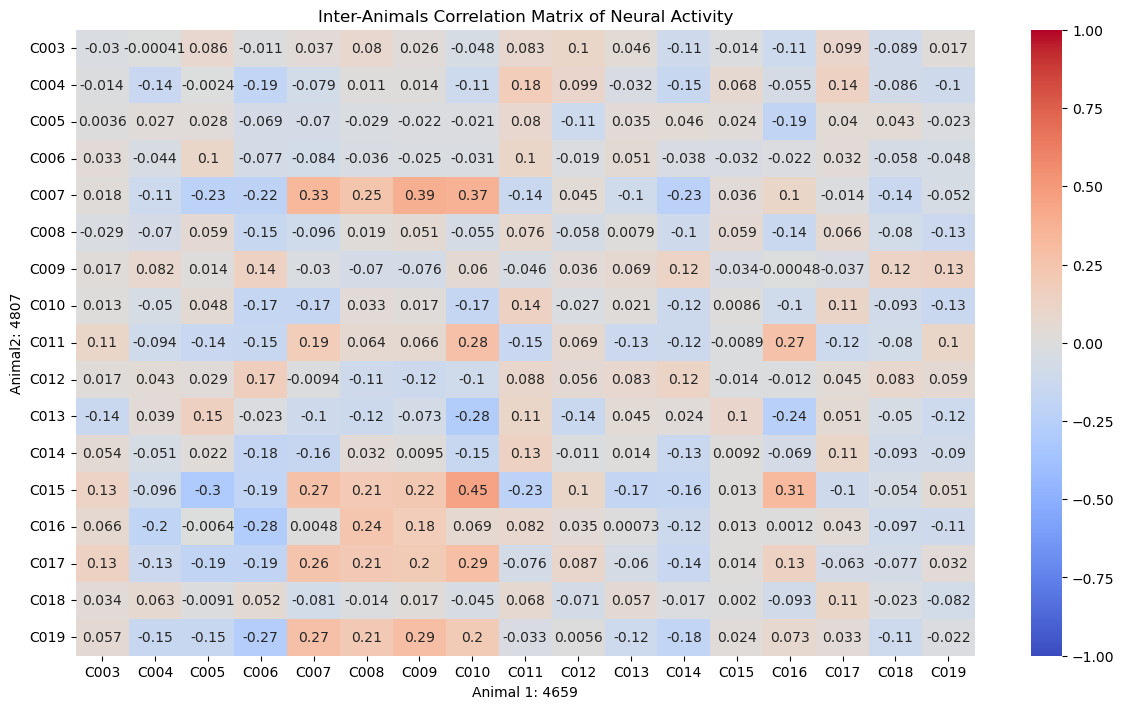

In [92]:
plt.figure(figsize=(12, 7))
sns.heatmap(df_r_values, annot=True,
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Inter-Animals Correlation Matrix of Neural Activity')
plt.tight_layout()
plt.xlabel('Animal 1: 4659')
plt.ylabel('Animal2: 4807')
plt.savefig('correlation_matrix_subset.png')
plt.show()

current notes:
- when not saved as a csv (as in this tutorial) the correlation function outputs dataframes with dtype object instead of float. This isn't a problem for the snakefile or running correlations.py. In this notebook I saved a csv and loaded it to correctly typecase the values as floats as seen below
- for the normalized dataset, the time values are lost in the final output csv that would be saved by running normalize_data.py. This causes problems when loading normalized data into the AnimalData class, as loading it into the class structure takes the first 4 columns as non cell data. Once this has been resolved this message will be removed and the tutorial file will be updated.

In [65]:
r_value_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, C003 to C019
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   C003    17 non-null     object
 1   C004    17 non-null     object
 2   C005    17 non-null     object
 3   C006    17 non-null     object
 4   C007    17 non-null     object
 5   C008    17 non-null     object
 6   C009    17 non-null     object
 7   C010    17 non-null     object
 8   C011    17 non-null     object
 9   C012    17 non-null     object
 10  C013    17 non-null     object
 11  C014    17 non-null     object
 12  C015    17 non-null     object
 13  C016    17 non-null     object
 14  C017    17 non-null     object
 15  C018    17 non-null     object
 16  C019    17 non-null     object
dtypes: object(17)
memory usage: 2.9+ KB


In [72]:
r_value_matrix.to_csv('../data/correlation_matirix_r_short.csv')

In [75]:
df_r_values = pd.read_csv('../data/correlation_matirix_r_short.csv', index_col=0)
df_r_values.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, C003 to C019
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C003    17 non-null     float64
 1   C004    17 non-null     float64
 2   C005    17 non-null     float64
 3   C006    17 non-null     float64
 4   C007    17 non-null     float64
 5   C008    17 non-null     float64
 6   C009    17 non-null     float64
 7   C010    17 non-null     float64
 8   C011    17 non-null     float64
 9   C012    17 non-null     float64
 10  C013    17 non-null     float64
 11  C014    17 non-null     float64
 12  C015    17 non-null     float64
 13  C016    17 non-null     float64
 14  C017    17 non-null     float64
 15  C018    17 non-null     float64
 16  C019    17 non-null     float64
dtypes: float64(17)
memory usage: 2.4+ KB


In [78]:
cells = animal_1_data.cell_data.keys()
cells

dict_keys(['C003', 'C004', 'C005', 'C006', 'C007', 'C008', 'C009', 'C010', 'C011', 'C012', 'C013', 'C014', 'C015', 'C016', 'C017', 'C018', 'C019'])